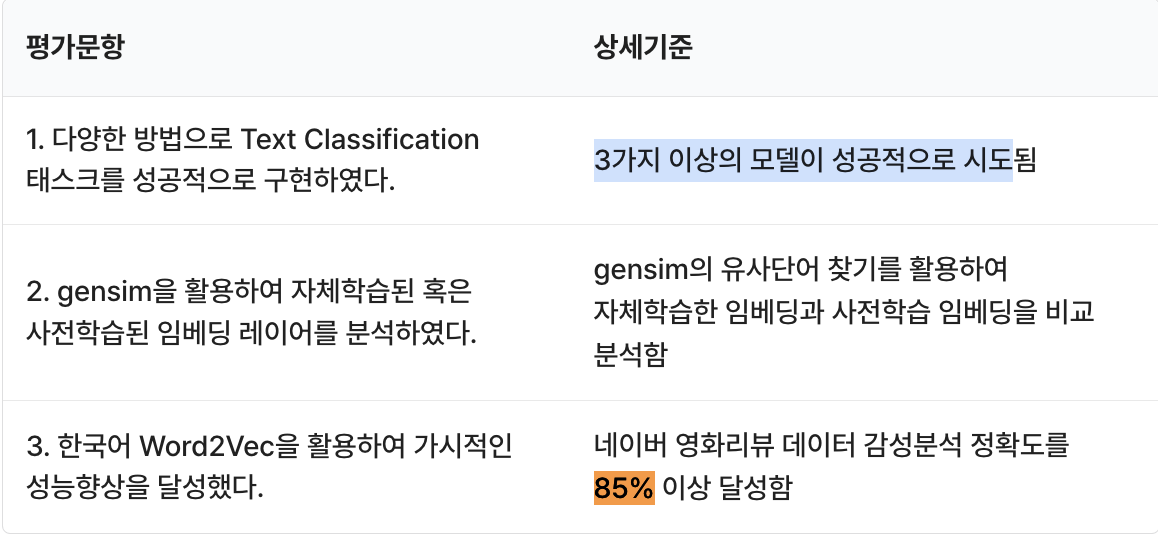

In [1]:
import pandas as pd # 1.3.3
import konlpy # 0.5.2
import gensim # 4.1.2
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow import keras
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [32]:
train_data.shape

(150000, 3)

In [5]:
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [6]:
test_data.head(10)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


## 2) 데이터로더 구성
`imdb.data_loader()`와 동일하게 동작하는  
자신만의 `data_loader`를 만들어 보는 것으로 시작합니다.  
`data_loader` 안에서는 다음을 수행해야 합니다.
1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환

##### train = 3817 + 5

In [8]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [11]:
train_data[train_data["document"].isnull() == True]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [17]:
train_data.duplicated(subset=["document"]).sum()

3817

In [12]:
train_data[train_data.duplicated(subset=["document"])]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


##### test = 3 + 842

In [5]:
test_data[test_data["document"].isnull() == True]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


In [16]:
test_data.duplicated(subset=["document"]).sum()

842

In [33]:
test_data[test_data.duplicated(subset=["document"])]

,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1
...,...,...,...
49731,7437033,별로,0
49760,5890883,최악이다,0
49767,4032953,최고,1
49841,8097768,2년이 지나도 잊혀지지 않는 소중한 드라마.,1


Wrapper for MeCab-ko morphological analyzer.

In [3]:
tokenizer = Mecab()
stopwords = ["그", "그래", "글쎄", "글쎄요", "네", "뭐", "아", "아니야", "아니요", "아우", "아유", "아이", '아이고', '아이구', '아이씨', '얘', "어", '어머', "어우", "어유", "어이", "어허", "에", "에이", "여보", "여보세요", "예", "오", "오케이", "와", "음", "응", "이봐", "임마", "자", "저", "저기", "참", "하.",
'괜히', '금방', '다', '대체', '도대체', '딱', '막', '맨날', '모두', '못', '무조건', '바로', '방금', '별로', "설마", "아무튼", '안', '어서', '얼른', '엄청', '열심히', '왜', '이리', '이미', '일단', '일찍', '잘', '잠시', '절대', '제대로', '제발', '제일', '조용히', '좀', '참', "확.",
'걔', '그', '그놈', '그쪽', '나', '내', '너', '너희', '네', '니', '당신', '뭐', '얘', '어디', '여기', '여러분', '우리', '이', '이놈', '이쪽', '자기', "자네", "쟤", "저거", '저기', '저희', "지.",
'개', '것', '녀석', '년', '놈', '달', '대', '대로', '리', '만', '명', '바', '번째', '살', '수', '시', '원', '이', '일', '장', '쪽', '차', '척', '초', '호.',
'그', '네', '단', '딴', '모든', '아무', '이', '저', '첫.',
'가', '내', '달', '못하', '않', '주.',
'그러면', '그런데', '그리고', '근데', '하지만.',
'아니.',
'이.',
'의', '가', '이', '은', '들', '는', '좀', '잘', '걍', 
'과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [35]:
len(stopwords)

167

dir(Mecab)  
1. 'morphs',  
2. 'nouns',  
3. 'pos']  

In [27]:
tokenizer.nouns("지루하지는 않은데 완전 막장임... 돈주고 보기에는....")

['완전', '막장', '돈']

In [26]:
tokenizer.pos("지루하지는 않은데 완전 막장임... 돈주고 보기에는....")

[('지루', 'XR'),
 ('하', 'XSA'),
 ('지', 'EC'),
 ('는', 'JX'),
 ('않', 'VX'),
 ('은데', 'EC'),
 ('완전', 'NNG'),
 ('막장', 'NNG'),
 ('임', 'VCP+ETN'),
 ('.', 'SF'),
 ('..', 'SY'),
 ('돈', 'NNG'),
 ('주', 'VV'),
 ('고', 'EC'),
 ('보', 'VX'),
 ('기', 'ETN'),
 ('에', 'JKB'),
 ('는', 'JX'),
 ('.', 'SF'),
 ('...', 'SY')]

In [28]:
tokenizer.morphs("지루하지는 않은데 완전 막장임... 돈주고 보기에는....")

['지루',
 '하',
 '지',
 '는',
 '않',
 '은데',
 '완전',
 '막장',
 '임',
 '.',
 '..',
 '돈',
 '주',
 '고',
 '보',
 '기',
 '에',
 '는',
 '.',
 '...']

In [29]:
np.array(list(train_data['label']))

array([0, 1, 0, ..., 0, 1, 0])

collections.Counter(a).most_common(n): a의 요소를 세어, 최빈값 n개를 반환

In [4]:
def load_data(train_data, test_data, num_words=50000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000 -4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

word_to_index
{'': 3,
 '.': 4,
 '영화': 5,
 '고': 6,
 '하': 7,

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word
{3: '',
 4: '.',
 5: '영화',
 6: '고',
 7: '하',  
 {3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '고',
 7: '하',

for word in sentence.split():  
    if word in word_to_index:  
        [word_to_index[word]  
    else:   
         word_to_index['<UNK>']  
[word_to_index['<BOS>']]+  

--- 
for sentence in sentences:  
         get_encoded_sentence(sentence, word_to_index)  
         
---
for index in encoded_sentence[1:]: #[1:]를 통해 <BOS>를 제외  
         if index in index_to_word:  
             index_to_word[index]   
         else:  
             '<UNK>'  
' '.join 

--- 
for encoded_sentence in encoded_sentences:  
         get_decoded_sentence(encoded_sentence, index_to_word) 

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [44]:
get_decoded_sentences(X_train[:10], index_to_word)

['빙 . . 진짜 짜증 네요 목소리',
 '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 구나',
 '재 <UNUSED>',
 '이야기 구먼 . . 솔직히 재미 없 . . 평점 조정',
 '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 보이 기 했 던 <UNUSED> <UNUSED> 너무나 이뻐 보였',
 '<UNUSED> 3 세 부터 초등 학교 1 학년 생 인 8 용 영화 . ㅋㅋㅋ . .. 별반 아까움 .',
 '긴장감 을 살려 지 못했 .',
 '반개 아깝 욕 나온다 <UNUSED> <UNUSED> 연기 생활 몇 인지 . . 정말 발 로 해도 그것 보단 낫 겟 납치 . 감금 반복 반복 . . 드라마 가족 없 연기 하 사람 <UNUSED>',
 '없 는데 재미 있 몇 되 영화',
 '평점 낮 건데 ? 꽤 볼 만한데 . . 헐리우드 식 화려 함 너무 <UNUSED> 있 ?']

### 3) 모델 구성을 위한 데이터 분석 및 가공
1. 데이터셋 내 문장 길이 분포
2. 적절한 최대 문장 길이 지정
3. `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가

In [ ]:
X_train[0]
# [61, 856, 4, 4, 31, 199, 26, 690]
X_test[0]
# [771, 111]
y_train[:10]
# array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1])
y_test[:10]
# array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [9]:
len(X_train), len(y_train), len(X_test), len(y_test)

(146182, 146182, 49157, 49157)

In [8]:
num_tokens = list(map(lambda x: len(x), X_train + X_test))
num_tokens = np.array(num_tokens)

num_tokens
[8,
 16,
 3,
 12,
 20,
 21,
 7,

In [47]:
print(np.mean(num_tokens))
print(np.max(num_tokens))
print(np.std(num_tokens))

14.391125172136645
116
11.643303392033584


In [9]:
max_tokens = np.mean(num_tokens) + (4 * np.std(num_tokens))

max_len = int(max_tokens)

max_tokens
# np.mean(num_tokens) + 2 * np.std(num_tokens)
# 37.677731956203814

60.96433874027098

In [13]:
# 8, 16 3, 12, ... < 37.67
np.sum(num_tokens < max_tokens) / len(num_tokens)
# True들의 총 갯수 / 195339 # 약 93%

0.9969335360578276

`tf.keras.preprocessing.sequence.pad_sequences`  
(
    __sequences,
    maxlen=None__,
    dtype='int32',
    __padding='pre'__,
    truncating='pre',
    __value=0.0__,
)

Pads sequences to the same length.

__word_to_index[`<PAD>`]__ = 0

In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=max_len)

###  4) 모델 구성 및 validation set 구성
모델은 3가지 이상

In [61]:
x_train.shape

(146182, 37)

In [62]:
146182 * 0.4

58472.8

import numpy as np
series_input_train = np.expand_dims(series_input_train, axis=1)
weather_input_train = np.expand_dims(weather_input_train, axis=1)   

In [11]:
x_val = X_train[:30000]
y_val = y_train[:30000]

partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

In [13]:
partial_x_train.shape, partial_y_train.shape, x_val.shape, y_val.shape

((116182, 60), (116182,), (30000, 60), (30000,))

### CNN + Global

In [35]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 1000   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu', padding="same"))

model.add(tf.keras.layers.Conv1D(128, 7, activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(128, 7, activation='relu', padding="same"))
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 64)          448064    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 64)          28736     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 128)         57472     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 128)        

### LSTM

In [12]:
class LstmModel(keras.Model):
    def __init__(self, vocab_size = 20000, word_vector_dim = 1000):
        super().__init__()
        self.embed1 = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                                output_dim=word_vector_dim, 
                                                input_shape=(None, ))
        
        self.lstm1 = tf.keras.layers.LSTM(128)
#         self.lstm2 = tf.keras.layers.LSTM(128)
        
        self.dense1 = tf.keras.layers.Dense(128, activation="relu")
        self.drop1 = tf.keras.layers.Dropout(.5)
        
        self.dense2 = tf.keras.layers.Dense(64, activation="relu")
        self.dense3 = tf.keras.layers.Dense(32, activation="relu")
        
        self.drop2 = tf.keras.layers.Dropout(.5)
        self.out1 = tf.keras.layers.Dense(1, activation="sigmoid")
        
    def call(self, x):
        x = self.embed1(x)
        
        x = self.lstm1(x)
#         x = self.lstm2(x)
        
        x = self.dense1(x)
        x = self.drop1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        
        x = self.drop2(x)
        x = self.out1(x)
        
        return x

In [13]:
model = LstmModel()

In [14]:
model.summary()
# subclass의 특징인가봐유

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

### GlobalMaxPooling

In [44]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 1000   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())

# model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
global_max_pooling1d (Global (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                16016     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 10,016,033
Trainable params: 10,016,033
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   verbose=1, patience=5)
mc = ModelCheckpoint('lstm_best_model.h5', monitor='val_loss', 
                     mode='min', save_best_only=True)

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### CNN + Global

In [37]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es, mc])

Epoch 1/20
169/169 [==============================] - 39s 42ms/step - loss: 0.4514 - accuracy: 0.7772 - val_loss: 0.3453 - val_accuracy: 0.8478
Epoch 2/20
169/169 [==============================] - 7s 41ms/step - loss: 0.2943 - accuracy: 0.8800 - val_loss: 0.3346 - val_accuracy: 0.8519
Epoch 3/20
169/169 [==============================] - 7s 40ms/step - loss: 0.1957 - accuracy: 0.9266 - val_loss: 0.4089 - val_accuracy: 0.8471
Epoch 4/20
169/169 [==============================] - 7s 40ms/step - loss: 0.1052 - accuracy: 0.9623 - val_loss: 0.5449 - val_accuracy: 0.8390
Epoch 5/20
169/169 [==============================] - 7s 40ms/step - loss: 0.0641 - accuracy: 0.9773 - val_loss: 0.6619 - val_accuracy: 0.8360
Epoch 6/20
169/169 [==============================] - 7s 39ms/step - loss: 0.0426 - accuracy: 0.9847 - val_loss: 0.8565 - val_accuracy: 0.8386
Epoch 7/20
169/169 [==============================] - 7s 39ms/step - loss: 0.0331 - accuracy: 0.9877 - val_loss: 0.8507 - val_accuracy: 0.839

 ValueError: Negative dimension size caused by subtracting 7 from 6 for '{{node sequential_3/conv1d_11/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3/conv1d_11/conv1d/ExpandDims, sequential_3/conv1d_11/conv1d/ExpandDims_1)' with input shapes: [?,1,6,64], [1,7,64,64].

###  Global + early stopping

In [46]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es, mc])

Epoch 1/20
169/169 [==============================] - 4s 14ms/step - loss: 0.4718 - accuracy: 0.7986 - val_loss: 0.3575 - val_accuracy: 0.8428
Epoch 2/20
169/169 [==============================] - 2s 13ms/step - loss: 0.3092 - accuracy: 0.8701 - val_loss: 0.3497 - val_accuracy: 0.8485
Epoch 3/20
169/169 [==============================] - 2s 13ms/step - loss: 0.2484 - accuracy: 0.9013 - val_loss: 0.3638 - val_accuracy: 0.8482
Epoch 4/20
169/169 [==============================] - 2s 13ms/step - loss: 0.1895 - accuracy: 0.9295 - val_loss: 0.3962 - val_accuracy: 0.8433
Epoch 5/20
169/169 [==============================] - 2s 13ms/step - loss: 0.1264 - accuracy: 0.9588 - val_loss: 0.4456 - val_accuracy: 0.8404
Epoch 6/20
169/169 [==============================] - 2s 13ms/step - loss: 0.0715 - accuracy: 0.9798 - val_loss: 0.5112 - val_accuracy: 0.8380
Epoch 7/20
169/169 [==============================] - 2s 13ms/step - loss: 0.0381 - accuracy: 0.9907 - val_loss: 0.5698 - val_accuracy: 0.8364

### LSTM

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=2048,
                    validation_data=(x_val, y_val),
                    verbose=1)
#                     callbacks=[es, mc])

Epoch 1/10
57/57 [==============================] - 13s 163ms/step - loss: 0.4976 - accuracy: 0.7596 - val_loss: 0.3556 - val_accuracy: 0.8448
Epoch 2/10
57/57 [==============================] - 9s 158ms/step - loss: 0.3473 - accuracy: 0.8574 - val_loss: 0.3434 - val_accuracy: 0.8477
Epoch 3/10
57/57 [==============================] - 9s 160ms/step - loss: 0.3141 - accuracy: 0.8707 - val_loss: 0.3462 - val_accuracy: 0.8483
Epoch 4/10
57/57 [==============================] - 9s 162ms/step - loss: 0.2861 - accuracy: 0.8819 - val_loss: 0.3738 - val_accuracy: 0.8500
Epoch 5/10
57/57 [==============================] - 9s 162ms/step - loss: 0.2554 - accuracy: 0.8926 - val_loss: 0.3883 - val_accuracy: 0.8468
Epoch 6/10
57/57 [==============================] - 9s 162ms/step - loss: 0.2312 - accuracy: 0.9042 - val_loss: 0.4193 - val_accuracy: 0.8442
Epoch 7/10
57/57 [==============================] - 9s 167ms/step - loss: 0.2092 - accuracy: 0.9146 - val_loss: 0.4677 - val_accuracy: 0.8438
Epoch

In [16]:
model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  20000000  
_________________________________________________________________
lstm (LSTM)                  multiple                  578048    
_________________________________________________________________
dense (Dense)                multiple                  16512     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

### 6) Loss, Accuracy 그래프 시각화

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [50]:
history_dict = history.history

In [41]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### CNN + GlobalMaxPooling

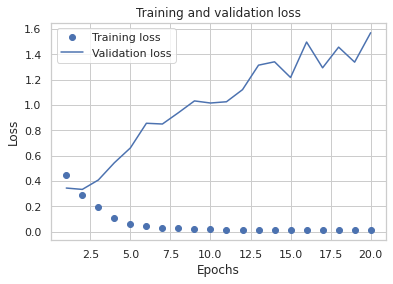

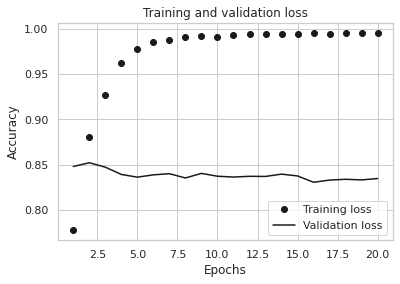

In [44]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
results = model.evaluate(x_test,  y_test, verbose=2)
results

1537/1537 - 4s - loss: 1.6024 - accuracy: 0.8316


[1.6023766994476318, 0.8316007852554321]

### GlobalMaxPooling

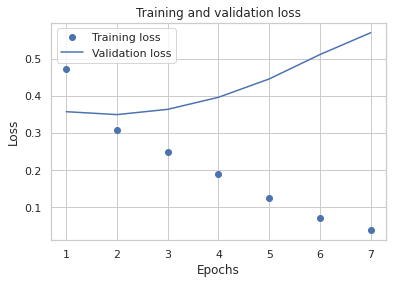

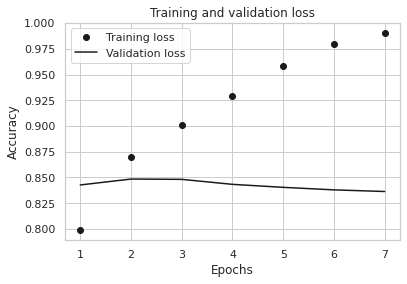

In [51]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
results = model.evaluate(X_test,  y_test, verbose=2)
results

1537/1537 - 2s - loss: 0.5787 - accuracy: 0.8336


[0.5786682367324829, 0.8336350917816162]

### LSTM with relu that is output 멍퉁이

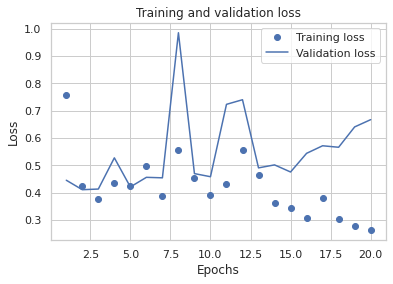

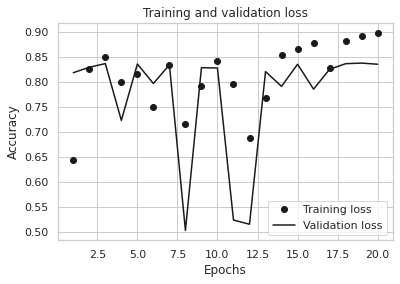

In [17]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
results = model.evaluate(X_test,  y_test, verbose=2)
results

1537/1537 - 4s - loss: 0.6606 - accuracy: 0.8285


[0.6605970859527588, 0.828549325466156]

## LSTM with sigmoid that is output

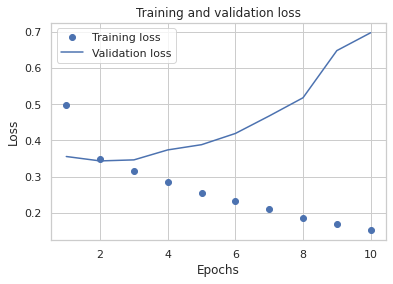

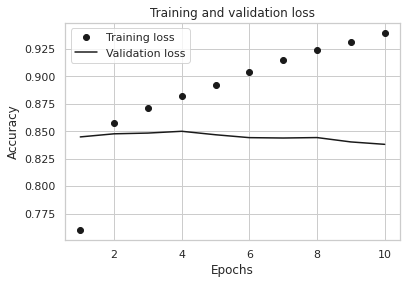

In [17]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
results = model.evaluate(X_test,  y_test, verbose=2)
results

1537/1537 - 4s - loss: 0.6788 - accuracy: 0.8382


[0.6787735819816589, 0.8381716012954712]

### 7) 학습된 Embedding 레이어 분석
만약 우리의 감성 분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것입니다. 한번 확인해 봅시다.

In [49]:
model.layers[0]

In [21]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


In [55]:
weights

array([[-0.08691385, -0.02608429, -0.06560357, ..., -0.108291  ,
        -0.13118218, -0.04833397],
       [-0.03207772, -0.00031921, -0.01234221, ..., -0.01676441,
         0.04526481,  0.00970121],
       [ 0.00391595, -0.03353139,  0.03498635, ..., -0.01898835,
        -0.03149077,  0.03475722],
       ...,
       [-0.04275602,  0.06409612, -0.01925269, ...,  0.04983319,
        -0.03087838,  0.00282479],
       [ 0.00597011,  0.00550832,  0.00878143, ...,  0.01104846,
        -0.00808332,  0.04564527],
       [ 0.02451771, -0.00035135, -0.00628679, ..., -0.00479976,
         0.01586237, -0.04892308]], dtype=float32)

In [56]:
word_vector_dim

1000

In [57]:
vocab_size

10000

In [29]:
vocab_size = 10000
word_vector_dim = 1000
# ValueError: could not broadcast input array from shape (1000,) into shape (2000,)

In [30]:
# # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_lstm_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm2.txt'
f = open(word2vec_lstm_file_path, 'w')
f.write('{} {}\n'.format(vocab_size -4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_lstm_file_path, binary=False)

### CNN + Golbal

word_vectors_cnn_global['ㅠㅠ']
>>> array([ 4.40528020e-02, -2.22891178e-02,  6.68337941e-02,  5.41829243e-02,
       -9.74881873e-02, -8.91523361e-02, -5.44765927e-02, -4.33994569e-02,

In [71]:
word_vectors_cnn_global.similar_by_word("ㅠㅠ")

[('~!!', 0.2898232340812683),
 ('아픔', 0.25491952896118164),
 ('엮', 0.24332869052886963),
 ('준', 0.24259229004383087),
 ('아쉽', 0.23799823224544525),
 ('굿', 0.23634271323680878),
 ('깨달음', 0.23515662550926208),
 ('기발', 0.229358971118927),
 ('존경', 0.22606396675109863),
 ('에요', 0.21741963922977448)]

In [81]:
word_vectors_cnn_global.similar_by_word("끝")

[('동기', 0.3603486120700836),
 ('뭘', 0.32886946201324463),
 ('떡밥', 0.3066491484642029),
 ('족', 0.2958037257194519),
 ('컨데', 0.29359492659568787),
 ('엽기', 0.2787788510322571),
 ('기생', 0.27438849210739136),
 ('쪼금', 0.2690306007862091),
 ('짜집기', 0.26370900869369507),
 ('발음', 0.2630634903907776)]

### Global

In [59]:
word_vectors_global.similar_by_word("ㅠㅠ")

[('고', 0.33616146445274353),
 ('.', 0.32284414768218994),
 ('영화', 0.31470853090286255),
 ('너무', 0.30033013224601746),
 ('드라마', 0.29666244983673096),
 ('해요', 0.29499053955078125),
 (',', 0.2857673168182373),
 ('하', 0.2847854495048523),
 ('내내', 0.2792905569076538),
 ('중', 0.2724933326244354)]

In [60]:
word_vectors_global.similar_by_word("끝")

[('까지', 0.3515363931655884),
 ('.', 0.3140244483947754),
 ('처음', 0.29558849334716797),
 ('하', 0.28319552540779114),
 ('너무', 0.27484646439552307),
 ('고', 0.2670179307460785),
 ('이거', 0.2648327350616455),
 ('영화', 0.26359763741493225),
 (',', 0.2630702257156372),
 ('보', 0.26161327958106995)]

### LSTM

In [30]:
word_vectors_lstm.similar_by_word("ㅠㅠ")

[('♥♥', 0.8301968574523926),
 ('♡', 0.8174625039100647),
 ('입니다', 0.8145949244499207),
 ('집니다', 0.8122943043708801),
 ('봣습니다', 0.8116657733917236),
 ('동원', 0.8091339468955994),
 ('봣어요', 0.8084798455238342),
 ('+_+', 0.8070281744003296),
 ('모자르', 0.8053524494171143),
 ('쩐', 0.8051376342773438)]

In [31]:
word_vectors_lstm.similar_by_word("끝")

[('나온', 0.7316474318504333),
 ('실사', 0.7285472750663757),
 ('건강', 0.7039760947227478),
 ('갈리', 0.6994677782058716),
 ('해졌', 0.6966599822044373),
 ('중간중간', 0.6948695182800293),
 ('노릇', 0.6888129115104675),
 ('떠나', 0.6883269548416138),
 ('제임스', 0.6875525712966919),
 ('피아노', 0.6868449449539185)]

In [32]:
word_vectors_lstm.similar_by_word("ㅠㅠ")

[('류덕환', 0.3411412835121155),
 ('타워', 0.3348848819732666),
 ('놓칠', 0.3157723546028137),
 ('근대', 0.31295904517173767),
 ('매트릭스', 0.30808204412460327),
 ('쉬운', 0.303413450717926),
 ('인게', 0.29735952615737915),
 ('24', 0.2959614396095276),
 ('울음', 0.2951754927635193),
 ('빠질', 0.2945837676525116)]

In [33]:
word_vectors_lstm.similar_by_word("끝")

[('->', 0.3530464172363281),
 ('바뀐', 0.34887099266052246),
 ('상대', 0.34290990233421326),
 ('우뢰매', 0.3368604779243469),
 ('핑계', 0.33190858364105225),
 ('무한도전', 0.32881686091423035),
 ('싸이', 0.3261847198009491),
 ('오로라', 0.32314178347587585),
 ('실망', 0.318978488445282),
 ('환영', 0.31649115681648254)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
한국어 Word2Vec은 /data 폴더 안에 있는 `word2vec_ko.model`을 활용하세요.  
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 `load()` 형태로 모델을 불러와주세요  

`binary` : bool, optional  
    If True, indicates whether the data is in __binary `word2vec` format.__

In [77]:
ls ~/data

GoogleNews-vectors-negative300.bin.gz*
ratings_test.txt*
ratings_train.txt*
word2vec_ko.model
word2vec_ko.model.trainables.syn1neg.npy
word2vec_ko.model.wv.vectors.npy


In [39]:
word2vec_ko_path = os.getenv("HOME") + "/data/word2vec_ko.model"
word2vec_ko = Word2VecKeyedVectors.load(word2vec_ko_path)

dir(word2vec_ko)
 'init_weights',
 'layer1_size',
 'lifecycle_events',
 'load',
 'make_cum_t
    
     'total_train_time',
 'train',
 'train_count',
 'update_weights',
 'vector_size',
 'window',
 'workers',
 'wv']

word2vec_ko.wv["끝"]
array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec_ko.wv:
        embedding_matrix[i] = word2vec_ko.wv[index_to_word[i]]

In [66]:
print(embedding_matrix)

[[ 0.04794858  0.66920628  0.93669496 ...  0.72060221  0.65965719
   0.90200792]
 [ 0.42189504  0.42086141  0.89786777 ...  0.27769736  0.99591421
   0.34611427]
 [ 0.66862357  0.85603917  0.33475208 ...  0.08548749  0.78023843
   0.51243026]
 ...
 [-0.78820521 -1.94006789 -0.90748    ...  4.22988605  0.29495776
  -0.68742418]
 [ 4.54130125 -0.2874538  -1.50424957 ...  5.66480732  3.56530738
  -1.50707424]
 [ 0.35373539  1.14368379 -1.1989454  ... -0.92010343  0.76029712
  -0.6505844 ]]


In [63]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 5000   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu', padding="same"))
# model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu', padding="same"))


# model.add(tf.keras.layers.Conv1D(32, 7, activation='relu', padding="same"))
# model.add(keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling1D(5))
# model.add(tf.keras.layers.Conv1D(32, 7, activation='relu', padding="same"))
# model.add(tf.keras.layers.GlobalMaxPooling1D())

# model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 5000)        50000000  
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 5000)        0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 16)          560016    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 16)         

In [64]:
# 학습의 진행
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
91/91 [==============================] - 15s 153ms/step - loss: 0.5533 - accuracy: 0.7110 - val_loss: 0.3990 - val_accuracy: 0.8207
Epoch 2/15
91/91 [==============================] - 14s 150ms/step - loss: 0.3704 - accuracy: 0.8521 - val_loss: 0.3662 - val_accuracy: 0.8386
Epoch 3/15
91/91 [==============================] - 14s 151ms/step - loss: 0.2813 - accuracy: 0.8986 - val_loss: 0.3988 - val_accuracy: 0.8332
Epoch 4/15
91/91 [==============================] - 14s 149ms/step - loss: 0.1932 - accuracy: 0.9351 - val_loss: 0.4548 - val_accuracy: 0.8335
Epoch 5/15
91/91 [==============================] - 13s 148ms/step - loss: 0.1234 - accuracy: 0.9621 - val_loss: 0.5414 - val_accuracy: 0.8278
Epoch 6/15
69/91 [=====================>........] - ETA: 2s - loss: 0.0831 - accuracy: 0.9735

KeyboardInterrupt: 

KeyboardInterrupt                         Traceback (most recent call last)  
연예인분들 만나러 가야하는데 시간 계산을 못했다;;;;그래서 정지 시키고 빨리 나가봤다 

In [55]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 100  

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=max_len, 
                                 trainable=True))
# model.add(keras.layers.Conv1D(16, 7, activation='relu', padding="same"))
# model.add(keras.layers.MaxPooling1D(5))

# model.add(keras.layers.Conv1D(16, 7, activation='relu', padding="same"))
# model.add(keras.layers.GlobalMaxPooling1D())


# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dropout(0.25))
# model.add(keras.layers.Dense(1, activation='sigmoid'))
# model.add(keras.layers.LSTM(16))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 37, 100)           1000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 1,007,905
Trainable params: 1,007,905
Non-trainable params: 0
____________________________________________

In [41]:
class LstmModel(keras.Model):
    def __init__(self, vocab_size = 20000, word_vector_dim = 2000):
        super().__init__()
        self.embed1 = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                                output_dim=word_vector_dim, 
                                                input_shape=(None, ))
        
#         self.lstm1 = tf.keras.layers.LSTM(32)
        self.lstm2 = tf.keras.layers.LSTM(256)
        
        self.dense1 = tf.keras.layers.Dense(256, activation="relu")
        self.dense2 = tf.keras.layers.Dense(128, activation="relu")
        self.drop1 = tf.keras.layers.Dropout(.5)
    
        self.dense3 = tf.keras.layers.Dense(64, activation="relu")
        
        self.drop2 = tf.keras.layers.Dropout(.5)
        self.out1 = tf.keras.layers.Dense(1, activation="sigmoid")
        # relu했던 멍퉁이가 궁금해서 softmax로 바꾸고 호대게 혼나서 sigmoid바꾼 썰
    def call(self, x):
        x = self.embed1(x)
        
#         x = self.lstm1(x)
        x = self.lstm2(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.drop1(x)
    
        x = self.dense3(x)
        
        x = self.drop2(x)
        x = self.out1(x)
        
        return x

In [42]:
model = LstmModel()

In [50]:
# 학습의 진행
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])              

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 12,
                    batch_size= 2048,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/12
57/57 [==============================] - 19s 312ms/step - loss: 0.4374 - accuracy: 0.7951 - val_loss: 0.3478 - val_accuracy: 0.8477
Epoch 2/12
57/57 [==============================] - 18s 319ms/step - loss: 0.3354 - accuracy: 0.8570 - val_loss: 0.3509 - val_accuracy: 0.8495
Epoch 3/12
57/57 [==============================] - 19s 327ms/step - loss: 0.3027 - accuracy: 0.8713 - val_loss: 0.3669 - val_accuracy: 0.8476
Epoch 4/12
57/57 [==============================] - 18s 318ms/step - loss: 0.2761 - accuracy: 0.8829 - val_loss: 0.3519 - val_accuracy: 0.8520
Epoch 5/12
57/57 [==============================] - 18s 314ms/step - loss: 0.2497 - accuracy: 0.8958 - val_loss: 0.3613 - val_accuracy: 0.8555
Epoch 6/12
57/57 [==============================] - 18s 316ms/step - loss: 0.2251 - accuracy: 0.9071 - val_loss: 0.3686 - val_accuracy: 0.8513
Epoch 7/12
57/57 [==============================] - 18s 318ms/step - loss: 0.2025 - accuracy: 0.9178 - val_loss: 0.4084 - val_accuracy: 0.8507

In [55]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.6559 - accuracy: 0.8374
[0.6559451222419739, 0.8374188542366028]


### LSTM SubClassing 
output을 relu로 하다니.. 멍퉁이 멍퉁이!

In [34]:
# 학습의 진행
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
114/114 [==============================] - 8s 61ms/step - loss: 0.6475 - accuracy: 0.7624 - val_loss: 0.4534 - val_accuracy: 0.8285
Epoch 2/20
114/114 [==============================] - 7s 58ms/step - loss: 0.5185 - accuracy: 0.8167 - val_loss: 0.5100 - val_accuracy: 0.8070
Epoch 3/20
114/114 [==============================] - 7s 59ms/step - loss: 0.4923 - accuracy: 0.8335 - val_loss: 0.4531 - val_accuracy: 0.8322
Epoch 4/20
114/114 [==============================] - 7s 59ms/step - loss: 0.4678 - accuracy: 0.8411 - val_loss: 0.4702 - val_accuracy: 0.8466
Epoch 5/20
114/114 [==============================] - 7s 60ms/step - loss: 0.4521 - accuracy: 0.8539 - val_loss: 0.5117 - val_accuracy: 0.8513
Epoch 6/20
114/114 [==============================] - 7s 60ms/step - loss: 0.4370 - accuracy: 0.8584 - val_loss: 0.4647 - val_accuracy: 0.8515
Epoch 7/20
114/114 [==============================] - 7s 61ms/step - loss: 0.4276 - accuracy: 0.8635 - val_loss: 0.5027 - val_accuracy: 0.8522

In [52]:
history_dict = history.history

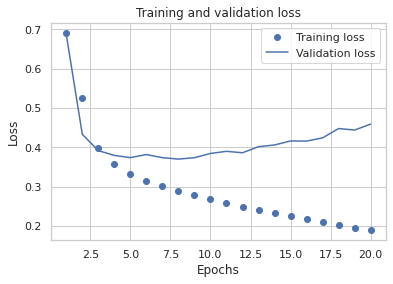

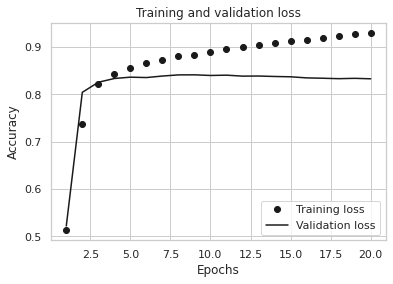

In [42]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

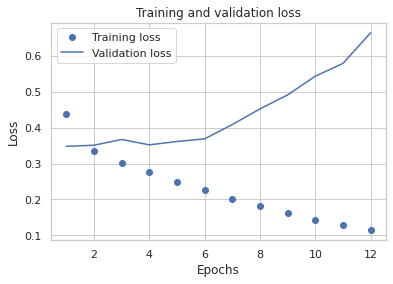

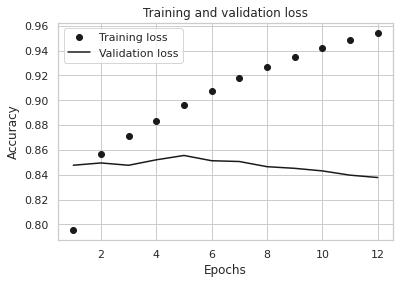

In [53]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 최최최최종

In [66]:
# 학습의 진행
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])              

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 8,
                    batch_size= 2048,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
57/57 [==============================] - 37s 625ms/step - loss: 0.4812 - accuracy: 0.7732 - val_loss: 0.3604 - val_accuracy: 0.8393
Epoch 2/8
57/57 [==============================] - 36s 640ms/step - loss: 0.3514 - accuracy: 0.8541 - val_loss: 0.3437 - val_accuracy: 0.8503
Epoch 3/8
57/57 [==============================] - 36s 626ms/step - loss: 0.3143 - accuracy: 0.8695 - val_loss: 0.3363 - val_accuracy: 0.8561
Epoch 4/8
57/57 [==============================] - 36s 630ms/step - loss: 0.2817 - accuracy: 0.8851 - val_loss: 0.3649 - val_accuracy: 0.8558
Epoch 5/8
57/57 [==============================] - 36s 626ms/step - loss: 0.2501 - accuracy: 0.8978 - val_loss: 0.4357 - val_accuracy: 0.8364
Epoch 6/8
57/57 [==============================] - 36s 627ms/step - loss: 0.2247 - accuracy: 0.9103 - val_loss: 0.3791 - val_accuracy: 0.8548
Epoch 7/8
57/57 [==============================] - 36s 628ms/step - loss: 0.1960 - accuracy: 0.9231 - val_loss: 0.4082 - val_accuracy: 0.8508
Epoch 

In [67]:
model.summary()

Model: "lstm_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  40000000  
_________________________________________________________________
lstm_8 (LSTM)                multiple                  2311168   
_________________________________________________________________
dense_17 (Dense)             multiple                  65792     
_________________________________________________________________
dense_18 (Dense)             multiple                  32896     
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  8256      
_________________________________________________________________
dropout_9 (Dropout)          multiple                 

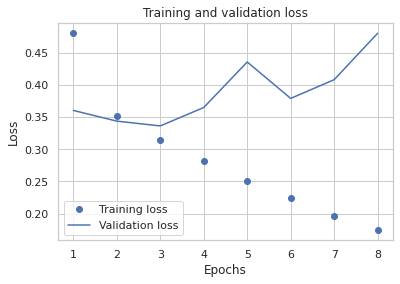

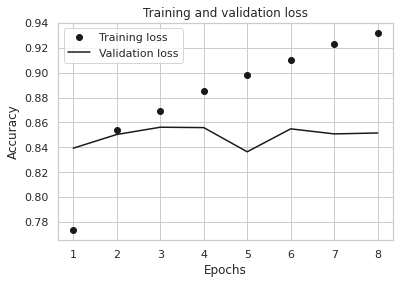

In [68]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [69]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.4774 - accuracy: 0.8496
[0.4773629605770111, 0.8496450185775757]


## 최최최최최초치ㅗ치ㅗ치ㅗ치ㅗ치ㅗ치ㅗ치ㅗ치ㅗ치ㅗ치ㅚ초치ㅚ종 젭알

In [43]:
# 학습의 진행
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])              

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 6,
                    batch_size= 2048,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/6
57/57 [==============================] - 37s 625ms/step - loss: 0.4782 - accuracy: 0.7711 - val_loss: 0.3504 - val_accuracy: 0.8453
Epoch 2/6
57/57 [==============================] - 37s 642ms/step - loss: 0.3557 - accuracy: 0.8521 - val_loss: 0.3493 - val_accuracy: 0.8470
Epoch 3/6
57/57 [==============================] - 35s 619ms/step - loss: 0.3152 - accuracy: 0.8696 - val_loss: 0.3520 - val_accuracy: 0.8479
Epoch 4/6
57/57 [==============================] - 36s 633ms/step - loss: 0.2837 - accuracy: 0.8831 - val_loss: 0.3451 - val_accuracy: 0.8545
Epoch 5/6
57/57 [==============================] - 36s 630ms/step - loss: 0.2535 - accuracy: 0.8972 - val_loss: 0.3561 - val_accuracy: 0.8566
Epoch 6/6
57/57 [==============================] - 36s 627ms/step - loss: 0.2240 - accuracy: 0.9101 - val_loss: 0.3839 - val_accuracy: 0.8529


In [44]:
model.summary()

Model: "lstm_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  40000000  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  2311168   
_________________________________________________________________
dense_7 (Dense)              multiple                  65792     
_________________________________________________________________
dense_8 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  8256      
_________________________________________________________________
dropout_5 (Dropout)          multiple                 

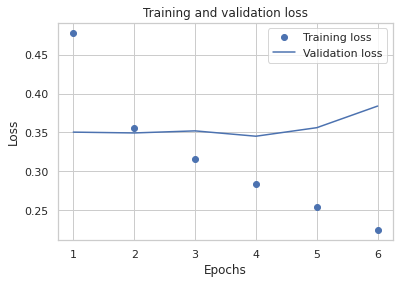

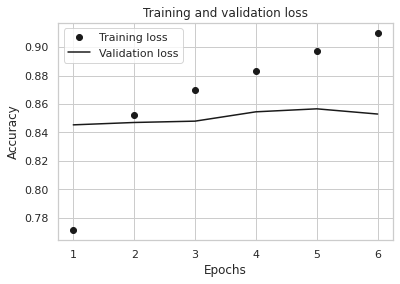

In [45]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'ko', label='Training loss')
plt.plot(epochs, val_acc, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3813 - accuracy: 0.8503
[0.38128766417503357, 0.8502553105354309]


# 회고짱

### 과정

1. 익숙했던 pd.read_csv가 아닌 pd.read_table를 통해서 txt를 불러왓네유!  
2. stop_words 설정을 했어요  
3. def load_data를 만들어주어요요요요  
    1. 데이터의 중복 제거
    2. NaN 결측치 제거
    3. 한국어 토크나이저로 토큰화
    4. 불용어(Stopwords) 제거
    5. 사전word_to_index 구성
    6. 텍스트 스트링을 사전 인덱스 스트링으로 변환  
4. 데이터 가공가공
    1. 데이터셋 내 문장 길이 분포 -> lambda 써봤다유 데헷!  
    2. 적절한 최대 문장 길이 지정  
    3. `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가  
5. 모델 layer 쌓기 및 validation 나누어보기!  
    1. CNN + GlobalMaxPooling -> sequential로 해봤다유!! 
    2. GlobalMaxPooling -> Functional로 해봐야하는디 까먹었다유!! 
    3. LSTM -> Subclass로 해봤다유 데헷!  
6. 모델 fit fit fit!!  

7. Loss & Accuracy 시각화화화화화화  

8. 학습시킨 Embedding 레이어 확인확인!   
`ㅠㅠ` 넣어보았다유!  
> '류덕환', 0.3411412835121155)  
> '♥♥', 0.8301968574523926),  
> '고', 0.33616146445274353),  
> '~!!', 0.2898232340812683),  

9. pre-trained 모델 `word2vec_ko.model` 사용해보기!  

### 뒤늦게 알게된 부분
1. model layer를 쌓고 output 부분에 relu 함수를 사용해서 그래프가 롤러코스터를 타고 있다는 부분을 발견했지요..  
2. optimizer adam말고 rmsprop도 사용해보기!  
3. GlobalMaxPooling1D()은 flatten같은 역할인거 같다유.  한 번만 쓰는 것 같다유...  
https://keras.io/api/layers/pooling_layers/global_max_pooling1d/
4. partial_x_train & x_val로 나눌 때 거꾸로 했넹.. 하.. 멍퉁이  
5. subclass로 구현하고나서 model.summary를 안해서 불러보니까 model.fit하고 나서 가능하다고 하네?! 오..  
6. 사용해봐야지 사용해봐야지 하면서 `EarlyStopping & ModelCheckpoint` 이번 프로젝트에 드디오 써보다니...
7. def load_data... 예시 코드 없는 줄 알고 스스로 구현해보는 도중에 발견!  
> 오아시스(?) 발견
8. tokenizer.morphs[pos, nouns] 이런 것들이 있구낭!  
9. pd.read_csv만 익숙한디 pd.read_table은 txt부를 때 쓰구낭!  
10. subclass로 해서 Output Shape 내용 -> multiple 로 보여주네?! 왜지? 

텍스트 감정 분석. 고거참 한국어여서 그런지 더더욱 생각보다 잘 분석을 못한다는 느낌이 들었습니다.  
그리고 정확도 올리기도 깐깐징어 수준이구요..  
조금 더 많은 stop_words 및 더 튼튼한 layer 쌓던가 다른 방식(cnn 방식이 아닌)의 layer를 쌓으면 더 좋은 결과가 있을 것 같습니다.  
더 큰 단어장, 더 큰 dimension을 준다면 약간의 효과가 더 있을 것만 같았다.  

__*Stop word.Korean_Version*__  
https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002865861  
https://mr-doosun.tistory.com/24  

레고로 모델 쌓는 것을 보여준다. 오..  
https://tykimos.github.io/2017/08/17/Text_Input_Binary_Classification_Model_Recipe/

P.S 진표, 준아님은 눈부신 후광을 가진 그런 연예인이 True.